%matplotlib notebook

In [35]:
import numpy as np
from numpy.linalg import inv, det, norm
from BZI.improved_tetrahedron_method import grid_and_tetrahedra
from BZI.pseudopots import Al_PP
from BZI.symmetry import find_orbitals, point_group
from BZI.sampling import sphere_pts
from BZI.plots import PlotMesh, PlotSphereMesh
from itertools import product
import copy
import math

In [3]:
ndiv0 = np.array([2,2,2])
ndiv1 = ndiv0 + 1
offset = [0.]*3
nbands = int(np.ceil(Al_PP.nvalence_electrons/2) + 5)
grid, tetrahedra = grid_and_tetrahedra(Al_PP, ndiv0, offset)
cell_vecs = Al_PP.lattice.reciprocal_vectors
invcell_vecs = Al_PP.lattice.vectors
grid = grid.flatten()
grid = np.round([np.dot(np.linalg.inv(cell_vecs), g) for g in grid], 12)

In [4]:
def RQ(a,b):
    """Find the rotation matrix that takes a to b.
    """
    a = np.array(a)
    b = np.array(b)
    a2 = np.dot(a,a)
    b2 = np.dot(b,b)
    if not np.isclose(a2, b2):
        msg = "The vectors must be the same length."
        raise ValueError(msg.format(a))
        
    v = np.cross(a,b)
    w = np.sqrt(a2*b2) + np.dot(a,b)
    Q = np.hstack([v,w])
    if np.count_nonzero(Q) == 0:
        if (np.allclose(a,b) or np.allclose(-a,b)):
            msg = ("The vectors provided are parallel and the "
                   "rotation axis is illdefined.")            
            raise ValueError(msg.format(a))        
        else:
            msg = "There is something wrong with the provided vectors."
            raise ValueError(msg.format(a))        
    else:
        Q = Q/np.linalg.norm(Q)
        x = Q[0]
        y = Q[1]
        z = Q[2]
        w = Q[3]
        return np.array([[w**2 + x**2 - y**2 - z**2, 2*(x*y - w*z), 2*(x*z + w*y)],
                         [2*(x*y + w*z), w**2 - x**2 + y**2 - z**2, 2*(y*z - w*x)],
                         [2*(x*z - w*y), 2*(y*z + w*x), w**2 - x**2 - y**2 + z**2]])

In [11]:
def MQ(a,b):
    """Find the reflection matrix that takes a to b.
    """
    
    a = np.array(a)
    b = np.array(b)
    a2 = np.dot(a,a)
    b2 = np.dot(b,b)
    if not np.isclose(a2, b2):
        msg = "The vectors must be the same length."
        raise ValueError(msg.format(a))
        
    n = (np.dot(b,b) + np.dot(a,b))*a - (np.dot(a,a) + np.dot(a,b))*b
    Q = n/norm(n)
    if np.count_nonzero(Q) == 0:
        if (np.allclose(a,b) or np.allclose(-a,b)):
            sign = lambda x: x and (1, -1)[x<0]
            return sign(np.dot(a,b))*np.eye(3,3)
        else:
            msg = "There is something wrong with the provided vectors."
            raise ValueError(msg.format(a))        
    else:
        Q = Q/np.linalg.norm(Q)
        x = Q[0]
        y = Q[1]
        z = Q[2]

        return np.array([[-x**2 + y**2 + z**2, -2*x*y, -2*x*z],
                         [-2*x*y, x**2 - y**2 + z**2, -2*y*z],
                         [-2*x*z, -2*y*z, x**2 + y**2 - z**2]])

In [126]:
def gen_point_group(lat_vecs):
    """Generate the point group of a lattice.
    """
    radius2 = max(np.sum(lat_vecs**2, axis=0))

    pts = sphere_pts(lat_vecs, radius2)
    point_group = [-np.eye(3,3)]
    for p1, p2 in product(pts, repeat=2):
        if (np.allclose(p1, p2) or np.allclose(-p1, p2)):
            continue
        elif np.isclose(np.dot(p1, p1), np.dot(p2, p2)):
            p1 = p1
            p2 = p2
            R = RQ(p1, p2)
            M = MQ(p1, p2)
            # RR = np.dot(R,M)
            if not any([np.allclose(pg, R) for pg in point_group]):
                point_group.append(R)
            if not any([np.allclose(pg, M) for pg in point_group]):
                point_group.append(M)
#             if not any([np.allclose(pg, RR) for pg in point_group]):
#                 point_group.append(RR)
        else:
            continue
    return point_group

In [117]:
def gen_rotations(lat_vecs):
    """Generate the point group of a lattice.
    """
    radius2 = max(np.sum(lat_vecs**2, axis=0))
    pts = sphere_pts(lat_vecs, radius2)
    point_group = []
    for p1, p2 in product(pts, repeat=2):
        if (np.allclose(p1, p2) or np.allclose(-p1, p2)):
            continue
        elif np.isclose(np.dot(p1, p1), np.dot(p2, p2)):
            R = RQ(p1, p2)
            if not any([np.allclose(pg, R) for pg in point_group]):
                point_group.append(R)
            else:
                continue
        else:
            continue
    return point_group

In [118]:
def gen_reflections(lat_vecs):
    """Generate the point group of a lattice.
    """
    
    radius2 = max(np.sum(lat_vecs**2, axis=0))
    pts = sphere_pts(lat_vecs, radius2)
    point_group = [-np.eye(3,3)]
    for p1, p2 in product(pts, repeat=2):
        if (np.allclose(p1, p2) or np.allclose(-p1, p2)):
            continue
        elif np.isclose(np.dot(p1, p1), np.dot(p2, p2)):
            M = MQ(p1, p2)
            if not any([np.allclose(pg, M) for pg in point_group]):
                point_group.append(M)
            else:
                continue
        else:
            continue
    return point_group

In [119]:
for pg in gen_point_group(cell_vecs):
    print(det(pg))
    print(np.round(np.dot(pg,pg.T)))

-1.0
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
1.0
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0. -0.  1.]]
-1.0
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
-1.0
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
1.0
[[ 1. -0.  0.]
 [-0.  1.  0.]
 [ 0.  0.  1.]]
-1.0
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
-1.0
[[ 1. -0.  0.]
 [-0.  1.  0.]
 [ 0.  0.  1.]]
1.0
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
-1.0
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
-1.0
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
1.0
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0. -0.  1.]]
-1.0
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0. -0.  1.]]
1.0
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
-1.0
[[ 1.  0.  0.]
 [ 0.  1. -0.]
 [ 0. -0.  1.]]
1.0
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
-1.0
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
1.0
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [-0. -0.  1.]]
-1.0
[[ 1.  0. -0.]
 [ 0.  1. -0.]
 [-0. -0.  1.]]
1.0
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
-1.0
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0

<IPython.core.display.Javascript object>


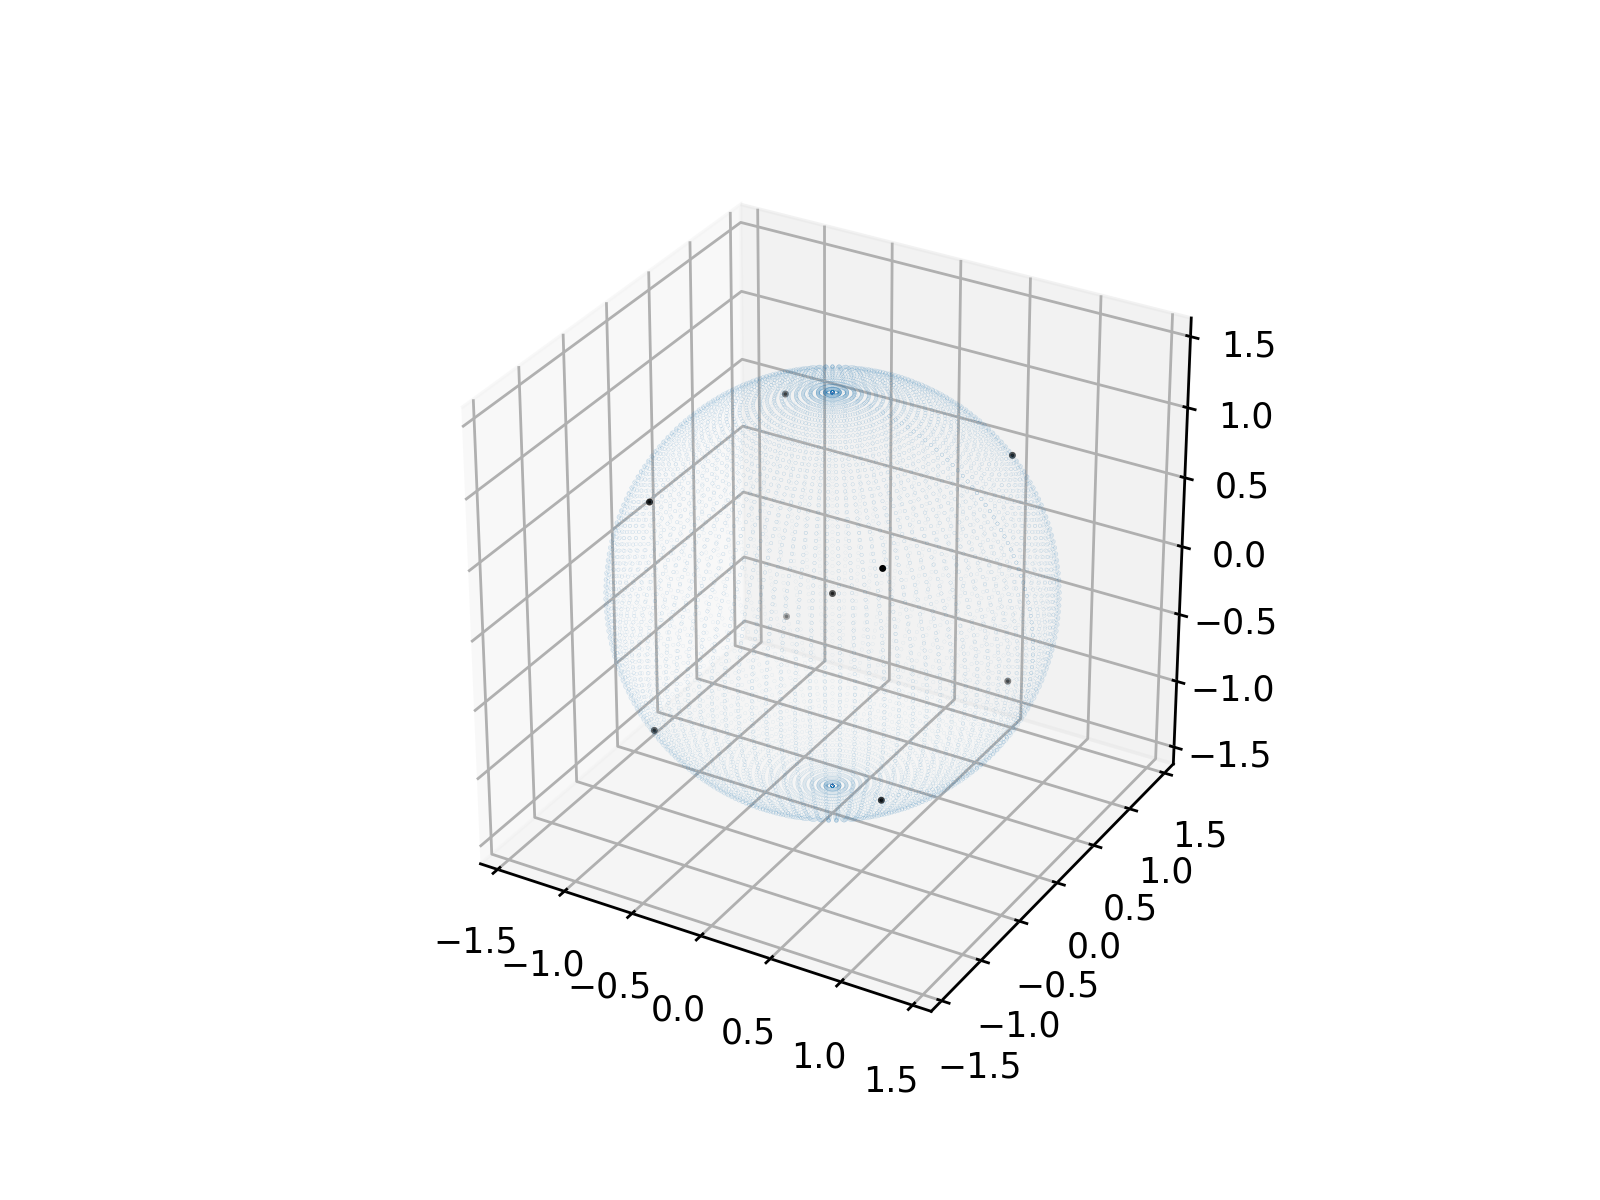

In [88]:
radius2 = max(np.sum(cell_vecs**2, axis=0))
pts = sphere_pts(cell_vecs, radius2)

PlotSphereMesh(pts, radius2)

In [138]:
pointgroup1= gen_point_group(cell_vecs)
pointgroup2 = point_group(cell_vecs)

icell_vecs = inv(cell_vecs)

# Convert to lattice coordinates.
for i,pg in enumerate(pointgroup1):
    pointgroup1[i] = np.round(np.dot(np.dot(icell_vecs, pg), pg))

for i,pg in enumerate(pointgroup2):
    pointgroup2[i] = np.round(np.dot(np.dot(icell_vecs, pg), pg))
    
# Compare the two groups
same = 0
missed = 0
for pg1 in pointgroup1:
    contained = False
    for pg2 in pointgroup2:
        if np.allclose(pg1, pg2):
            contained = True
            continue
    if contained == False:
        missed += 1
print(missed)

24


In [139]:
len(pointgroup1)

34

In [140]:
len(pointgroup2)

48

In [142]:
R = gen_rotations(cell_vecs)[0]